In [1]:

from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')

/hdd1/home/p22_cyyeung/miniconda3/envs/scrna/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [3]:
test = MyTestSet("./pretrain_less_class_2/query_pre.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [4]:
file = open("./pretrain_less_class_2/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
trainy = pd.read_csv("./pretrain_less_class_2/trainy_pre.csv")
classes = len(np.unique(trainy['celltype_l2']))

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)


mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./pretrain_less_class_2/checkpoint_model_pre.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [6]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

In [7]:
real_label = pd.read_csv("./pretrain_less_class_2/testy_pre.csv", index_col=0)
real_label.value_counts()

celltype_l2               
Brain Cancer                  135
Breast Cancer                 135
Colon/Colorectal Cancer       135
Endometrial/Uterine Cancer    135
Esophageal Cancer             135
Head and Neck Cancer          135
Kidney Cancer                 135
Liver Cancer                  135
Lung Cancer                   135
Ovarian Cancer                135
Pancreatic Cancer             135
Skin Cancer                   135
Name: count, dtype: int64

In [8]:
file = open("./pretrain_less_class_2/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

Lung Cancer                   145
Pancreatic Cancer             141
Brain Cancer                  137
Skin Cancer                   137
Colon/Colorectal Cancer       135
Endometrial/Uterine Cancer    135
Esophageal Cancer             135
Head and Neck Cancer          135
Kidney Cancer                 133
Liver Cancer                  130
Ovarian Cancer                130
Breast Cancer                 127
Name: count, dtype: int64

In [9]:
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype_l2"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype_l2"])
ari = adjusted_rand_score(real_label_2, pred_label_2)

print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.983, ARI = 0.964


In [10]:
import torch.nn.functional as nnf
pros = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred = mod(query)
    p = nnf.softmax(pred.data).cpu()
    pros.append(p)

In [11]:
prob = torch.cat(pros, dim=0)
prob

tensor([[0.0088, 0.0065, 0.0085,  ..., 0.0212, 0.0080, 0.0066],
        [0.0085, 0.0077, 0.0093,  ..., 0.0089, 0.0236, 0.0079],
        [0.0086, 0.0078, 0.0084,  ..., 0.0091, 0.0073, 0.0082],
        ...,
        [0.0048, 0.0047, 0.0049,  ..., 0.0044, 0.9466, 0.0053],
        [0.0068, 0.0064, 0.0084,  ..., 0.0068, 0.9225, 0.0077],
        [0.0083, 0.0073, 0.0074,  ..., 0.0068, 0.9089, 0.0077]])

In [12]:
max_prob, predicted_classes = torch.max(prob, axis=1)
max_prob

tensor([0.8920, 0.8865, 0.9095,  ..., 0.9466, 0.9225, 0.9089])

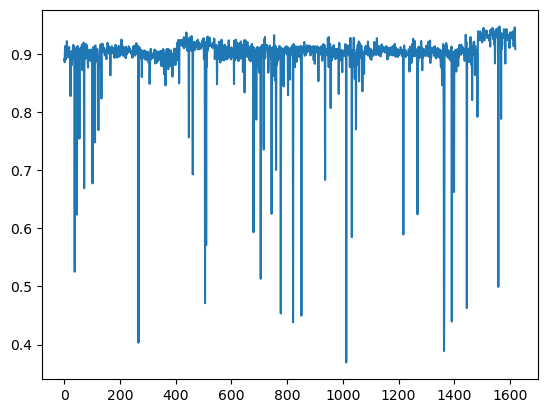

In [13]:
plt.plot(max_prob)

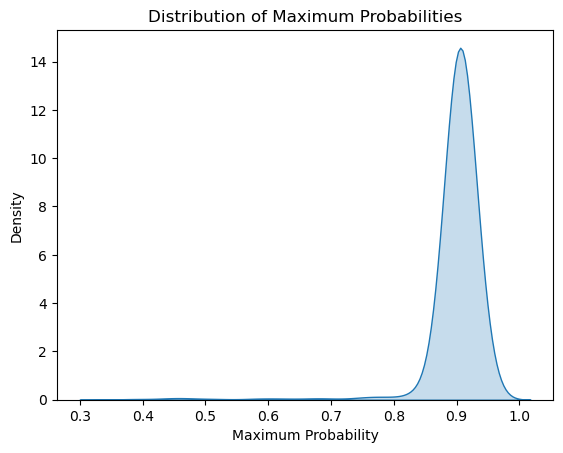

In [14]:
import seaborn as sns
sns.kdeplot(max_prob, bw_adjust=2, fill=True,)
plt.title("Distribution of Maximum Probabilities")
plt.xlabel("Maximum Probability")
plt.show()

In [15]:
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(real_label_2, prob, multi_class='ovr')
print("AUROC: %.03f" % auroc)

AUROC: 0.999


In [16]:
from torchmetrics.classification import AveragePrecision
average_precision = AveragePrecision(task="multiclass", num_classes=classes, average="weighted")
aurpc_weighted = average_precision(prob, torch.from_numpy(real_label_2))
print("AURPC (weighted): %.03f" % aurpc_weighted)

AURPC (weighted): 0.995


In [17]:
from torchmetrics.classification import AveragePrecision
average_precision = AveragePrecision(task="multiclass", num_classes=classes, average="macro")
aurpc_macro = average_precision(prob, torch.from_numpy(real_label_2))
print("AURPC (macro): %.03f" % aurpc_macro)

AURPC (macro): 0.995


In [18]:
from sklearn.metrics import f1_score
f1_score(real_label_2, pred_label_2, average=None)

array([0.99264706, 0.96946565, 1.        , 1.        , 0.99259259,
       0.99259259, 0.99253731, 0.98113208, 0.94285714, 0.98113208,
       0.96376812, 0.99264706])

In [19]:
f1_weighted = f1_score(real_label_2, pred_label_2, average='weighted')
print("F1-score(weighted): %.03f" % f1_weighted)

F1-score(weighted): 0.983


In [20]:
f1_macro = f1_score(real_label_2, pred_label_2, average='macro')
print("F1-score(weighted): %.03f" % f1_macro)

F1-score(weighted): 0.983


In [21]:
# Get class labels from label encoder
class_labels = le2.classes_

# Inverse transform the numeric labels to get class names
real_labels = le2.inverse_transform(real_label_2)
pred_labels = le2.inverse_transform(pred_label_2)

# Initialize an empty list to store data for the table
table_data = []

# Iterate through each sample's real label, predicted label, and maximum probability
for sample_idx, (real_label, pred_label, max_prob) in enumerate(zip(real_labels, pred_labels, max_prob)):
    # Create a dictionary to store sample data
    sample_data_dict = {
        'Real_Label': real_label,
        'Predicted_Label': pred_label,
        'Max_Probability': max_prob.item()  # Convert maximum probability tensor to a scalar
    }
    
    # Append the dictionary to the list
    table_data.append(sample_data_dict)

# Convert the list of dictionaries to a DataFrame
table_df = pd.DataFrame(table_data)

# Display the DataFrame
print(table_df)

table_df.to_csv("./pretrain_less_class_2/test_result.csv")

             Real_Label    Predicted_Label  Max_Probability
0           Lung Cancer        Lung Cancer         0.891951
1           Lung Cancer        Lung Cancer         0.886523
2           Lung Cancer        Lung Cancer         0.909499
3           Lung Cancer        Lung Cancer         0.914372
4           Lung Cancer        Lung Cancer         0.890432
...                 ...                ...              ...
1615  Pancreatic Cancer  Pancreatic Cancer         0.939760
1616  Pancreatic Cancer  Pancreatic Cancer         0.926624
1617  Pancreatic Cancer  Pancreatic Cancer         0.946565
1618  Pancreatic Cancer  Pancreatic Cancer         0.922538
1619  Pancreatic Cancer  Pancreatic Cancer         0.908931

[1620 rows x 3 columns]


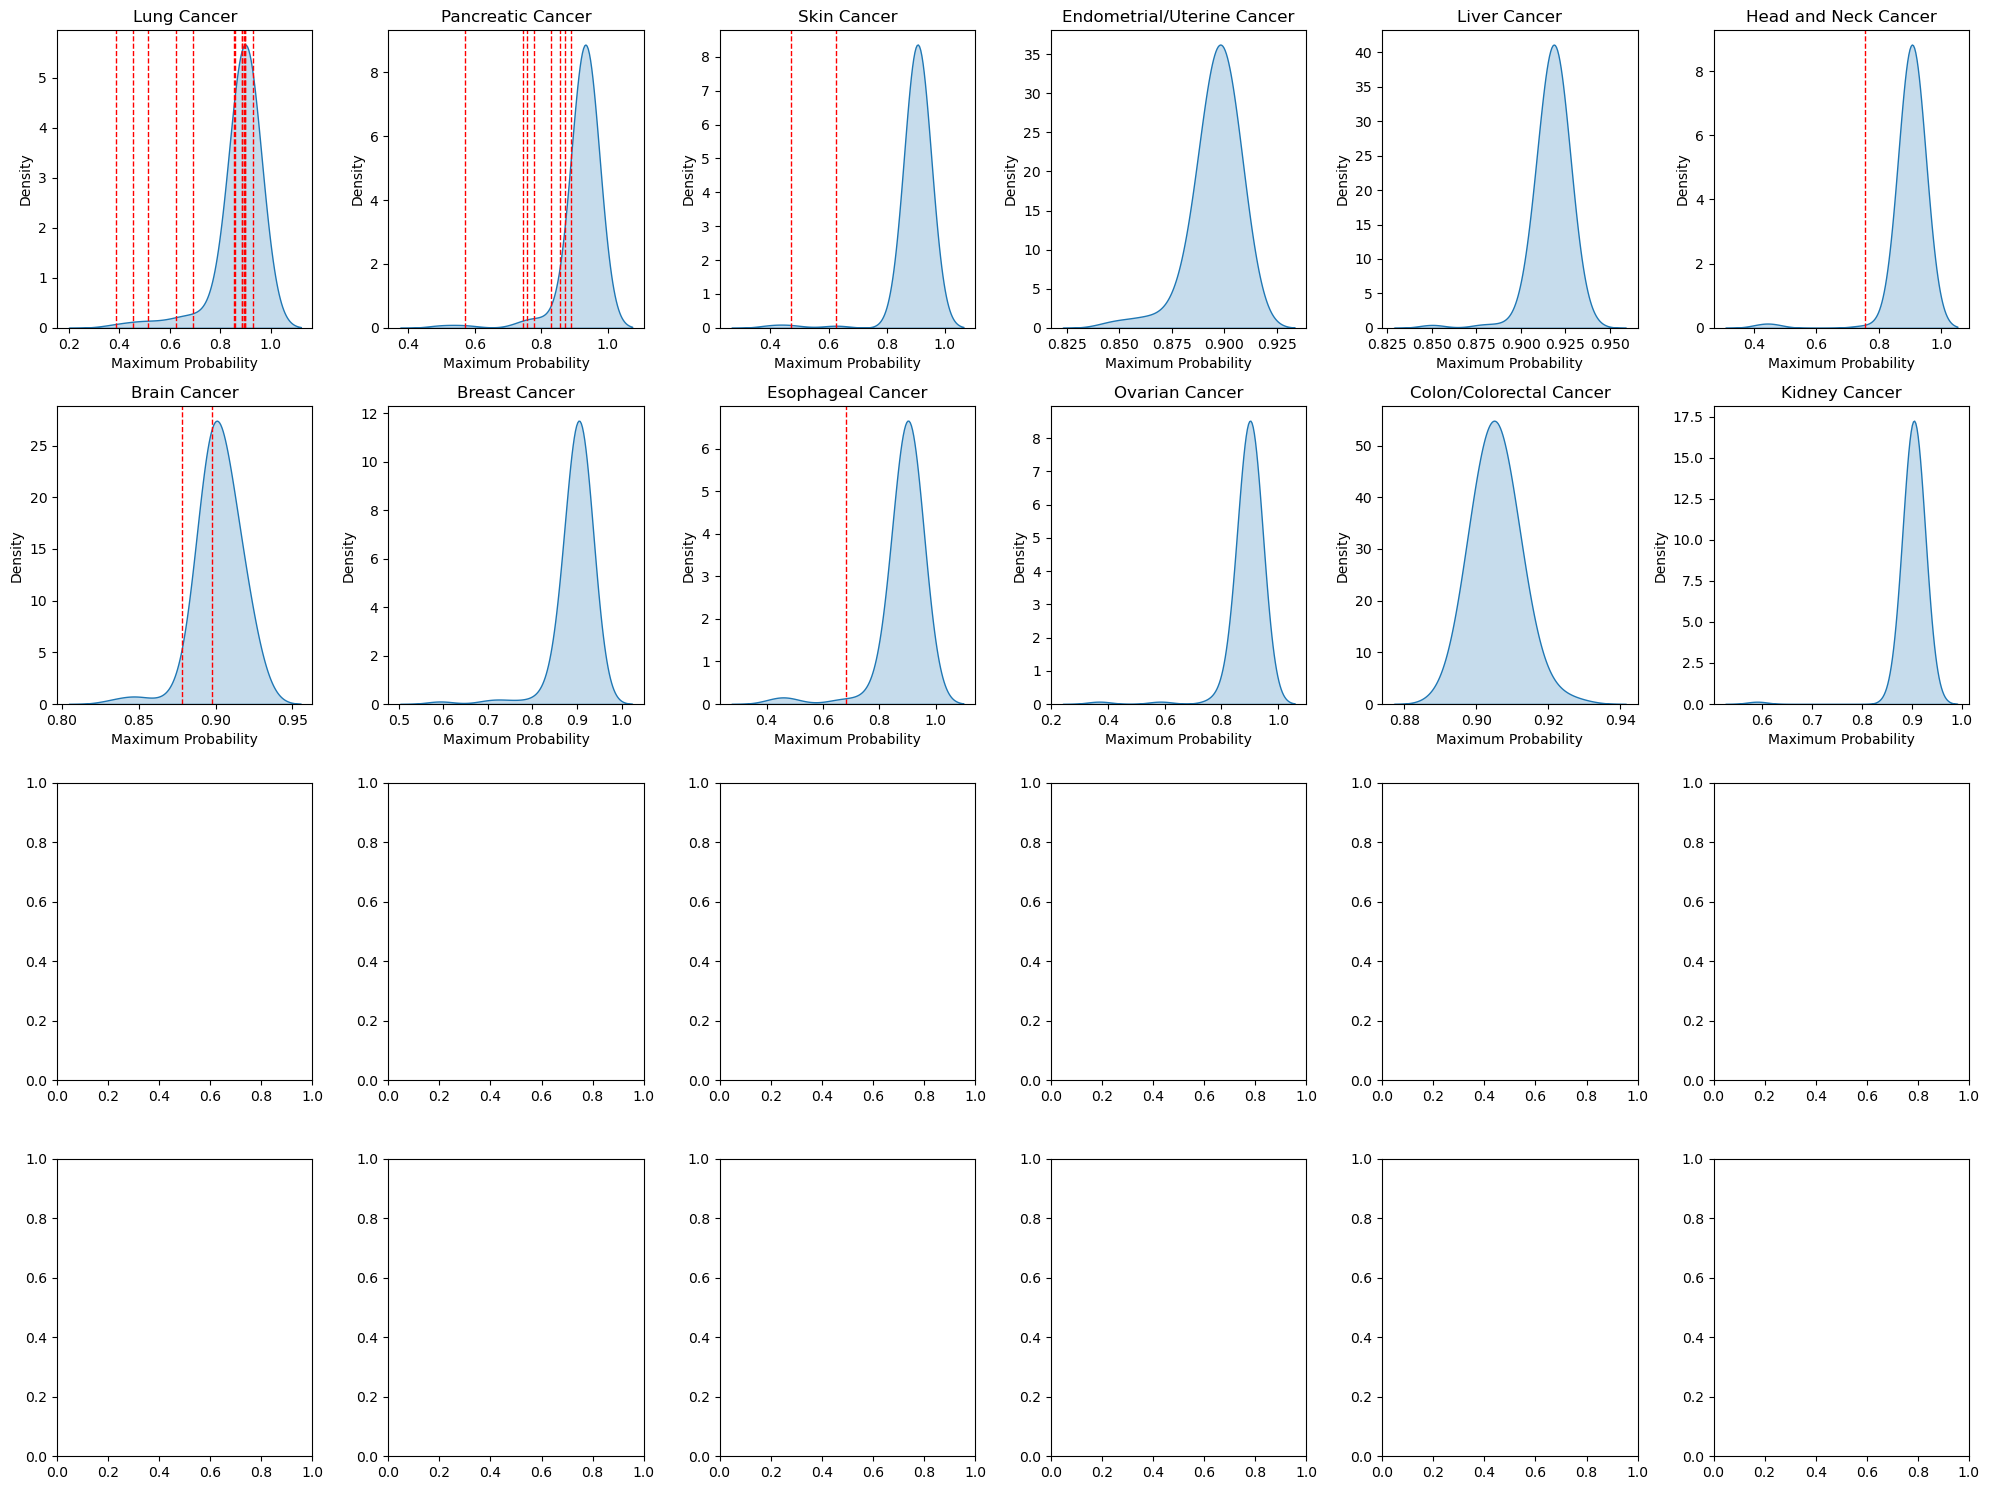

In [22]:
# Get unique predicted labels
unique_pred_labels = table_df['Predicted_Label'].unique()

# Define the number of rows and columns for subplots
num_rows = 2
num_cols = 6
num_plots = num_rows * num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Plot maximum probability distribution for each predicted class
for i, pred_label in enumerate(unique_pred_labels):
    # Calculate the row and column index for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # Filter the data for the current predicted label
    max_probs_class = table_df[table_df['Predicted_Label'] == pred_label]['Max_Probability']
    
    # Plot KDE plot for the maximum probabilities of the current predicted class
    sns.kdeplot(max_probs_class, bw_adjust=2, fill=True, ax=axes[row_idx, col_idx])
    
    # Label the wrong predictions with their maximum probabilities
    wrong_predictions = table_df[(table_df['Predicted_Label'] == pred_label) & (table_df['Real_Label'] != pred_label)]
    for idx, row in wrong_predictions.iterrows():
        axes[row_idx, col_idx].axvline(x=row['Max_Probability'], color='red', linestyle='--', linewidth=1)
    
    # Set title and labels for the subplot
    axes[row_idx, col_idx].set_title(f"{pred_label}")
    axes[row_idx, col_idx].set_xlabel("Maximum Probability")
    axes[row_idx, col_idx].set_ylabel("Density")

# Adjust layout
plt.tight_layout()

plt.savefig("pretrain_less_class_2/test_result_graph.png")

# Show the plot
plt.show()

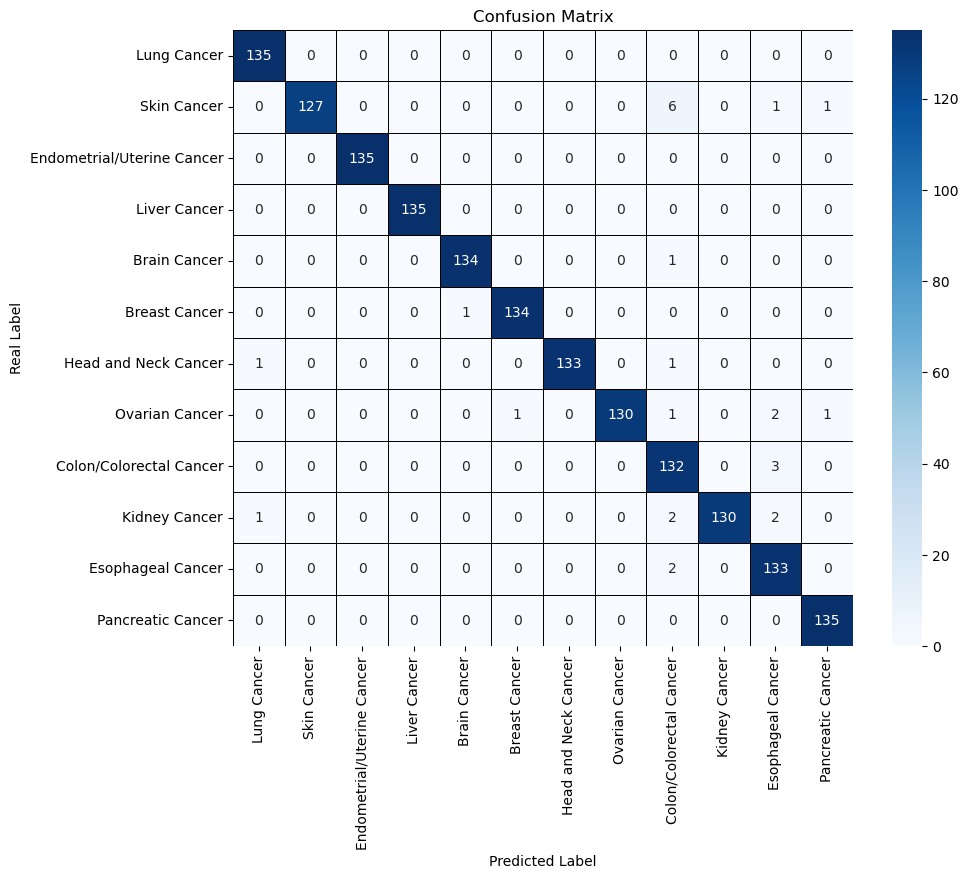

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(table_df['Real_Label'], table_df['Predicted_Label'])

# Get class labels
class_labels = table_df['Real_Label'].unique()

# Plot confusion matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Real Label')
plt.savefig("pretrain_less_class_2/condusion_matrix.png")
plt.show()